In [19]:
# data loading
import pandas as pd

# Load and convert datetime
users = pd.read_csv("users.csv")
logins = pd.read_csv("logins.csv")
transactions = pd.read_csv("transactions.csv")

logins["login_time"] = pd.to_datetime(logins["login_time"])
transactions["txn_time"] = pd.to_datetime(transactions["txn_time"])

# Sort before looping
logins = logins.sort_values(by=["user_id", "login_time"])
transactions = transactions.sort_values(by=["user_id", "txn_time"])

# Manual group-wise merge: most recent login before each transaction
merged_rows = []

for user_id, txn_group in transactions.groupby("user_id"):
    user_logins = logins[logins["user_id"] == user_id].sort_values("login_time")
    
    for _, txn in txn_group.iterrows():
        prior_logins = user_logins[user_logins["login_time"] <= txn["txn_time"]]
        if not prior_logins.empty:
            last_login = prior_logins.iloc[-1]
            merged_rows.append({
                **txn.to_dict(),
                "login_time": last_login["login_time"],
                "login_lat": last_login["location_lat"],
                "login_long": last_login["location_long"],
                "login_device": last_login["device_id"]
            })

merged = pd.DataFrame(merged_rows)
print("Manual merge successful. Sample result:")
merged.head()


Manual merge successful. Sample result:


,txn_id,user_id,txn_time,location_lat,location_long,device_id,txn_type,amount,is_fraud,login_time,login_lat,login_long,login_device
0,5365d72f-6569-4f03-be3b-930a7245ee33,user_1,2025-07-05 07:26:24,79.101645,125.584274,device_33,debit,6262.08,0,2025-07-04 09:49:03,-22.896798,147.657579,device_13
1,4f608213-7119-45ae-b79f-17ce71a3c45d,user_1,2025-07-08 20:37:03,54.518719,122.508410,device_81,debit,6495.06,0,2025-07-07 06:00:43,22.030131,-160.994051,device_1
2,28baa27c-6ce4-49b1-b09c-b8684ad70cc6,user_1,2025-07-12 03:43:10,57.495713,36.782101,device_25,debit,7365.21,0,2025-07-11 15:39:02,89.331201,-117.151929,device_43
3,d60c3ac6-b762-46e9-bd4c-046db4f86aee,user_1,2025-07-13 02:41:29,-9.634341,11.767940,device_33,debit,8119.32,0,2025-07-11 15:39:02,89.331201,-117.151929,device_43
4,28923783-ca6b-4d6a-892d-eaeacf5a742d,user_10,2025-06-24 05:32:33,-28.606154,97.488900,device_86,debit,264.34,0,2025-06-18 23:21:14,43.194440,-135.863611,device_78


In [17]:
print(transactions[["user_id", "txn_time"]].head(10))
print(logins[["user_id", "login_time"]].head(10))


       user_id            txn_time
2833    user_1 2025-06-18 17:59:52
3995    user_1 2025-06-25 02:46:21
8477    user_1 2025-07-05 07:26:24
306     user_1 2025-07-08 20:37:03
2726    user_1 2025-07-12 03:43:10
4727    user_1 2025-07-13 02:41:29
767    user_10 2025-06-24 05:32:33
6721   user_10 2025-07-01 08:07:36
4018   user_10 2025-07-13 04:16:42
38    user_100 2025-06-24 16:23:57
       user_id          login_time
7936    user_1 2025-06-26 04:16:21
9780    user_1 2025-07-04 09:49:03
2959    user_1 2025-07-06 11:47:19
7582    user_1 2025-07-07 06:00:43
4547    user_1 2025-07-11 15:39:02
5303    user_1 2025-07-15 18:58:54
9554    user_1 2025-07-15 23:29:35
10953  user_10 2025-06-18 23:21:14
7839   user_10 2025-07-01 16:05:36
707    user_10 2025-07-06 22:21:18


In [21]:
# feature engineering
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance (in km) between two points using Haversine formula.
    """
    R = 6371  # Radius of the Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c


In [22]:
# Apply Haversine distance
merged["haversine_km"] = haversine(
    merged["location_lat"], merged["location_long"],
    merged["login_lat"], merged["login_long"]
)

# Flag if transaction device is different from login device
merged["new_device"] = (merged["device_id"] != merged["login_device"]).astype(int)

# Time difference between login and transaction in minutes
merged["login_txn_gap_min"] = (merged["txn_time"] - merged["login_time"]).dt.total_seconds() / 60.0


In [23]:
# Z-score of login_txn_gap per user
merged["time_dev_z"] = merged.groupby("user_id")["login_txn_gap_min"].transform(
    lambda x: (x - x.mean()) / (x.std() + 1e-5)
)


In [24]:
merged[[
    "user_id", "txn_time", "login_time",
    "haversine_km", "new_device",
    "login_txn_gap_min", "time_dev_z"
]].head()


,user_id,txn_time,login_time,haversine_km,new_device,login_txn_gap_min,time_dev_z
0,user_1,2025-07-05 07:26:24,2025-07-04 09:49:03,11424.976085,1,1297.350000,-0.425039
1,user_1,2025-07-08 20:37:03,2025-07-07 06:00:43,7168.123102,1,2316.333333,0.959945
2,user_1,2025-07-12 03:43:10,2025-07-11 15:39:02,3681.244057,1,724.133333,-1.204145
3,user_1,2025-07-13 02:41:29,2025-07-11 15:39:02,11125.507715,1,2102.450000,0.669239
4,user_10,2025-06-24 05:32:33,2025-06-18 23:21:14,15035.202667,1,7571.316667,-0.701003


In [26]:
# train model - random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Features to use
FEATURES = ["amount", "haversine_km", "new_device", "login_txn_gap_min"]
X = merged[FEATURES]
y = merged["is_fraud"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Train model
model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

print("Model Evaluation:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


Model Evaluation:
[[1985    0]
 [ 105    0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1985
           1       0.00      0.00      0.00       105

    accuracy                           0.95      2090
   macro avg       0.47      0.50      0.49      2090
weighted avg       0.90      0.95      0.93      2090



C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [29]:
# need to balance the training data by oversampling fraud cases.

from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Prepare dataset
FEATURES = ["amount", "haversine_km", "new_device", "login_txn_gap_min"]
X = merged[FEATURES]
y = merged["is_fraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# 2. Combine for resampling
df_train = X_train.copy()
df_train["is_fraud"] = y_train

# 3. Separate classes
fraud = df_train[df_train["is_fraud"] == 1]
non_fraud = df_train[df_train["is_fraud"] == 0]

# 4. Upsample minority class (fraud)
fraud_upsampled = resample(fraud,
                           replace=True,
                           n_samples=len(non_fraud),
                           random_state=42)

# 5. Combine back
balanced_train = pd.concat([non_fraud, fraud_upsampled])

X_train_bal = balanced_train.drop("is_fraud", axis=1)
y_train_bal = balanced_train["is_fraud"]

# 6. Train model
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train_bal, y_train_bal)

# 7. Predict
y_pred = model.predict(X_test)

# 8. Evaluate
print("Evaluation After Balancing:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))


Evaluation After Balancing:
[[1971   14]
 [ 104    1]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1985
           1       0.07      0.01      0.02       105

    accuracy                           0.94      2090
   macro avg       0.51      0.50      0.49      2090
weighted avg       0.91      0.94      0.92      2090



In [30]:
merged.to_csv("merged_anomaly_features.csv", index=False)
print("File saved as: merged_anomaly_features.csv")


File saved as: merged_anomaly_features.csv


In [31]:
!pip install seaborn


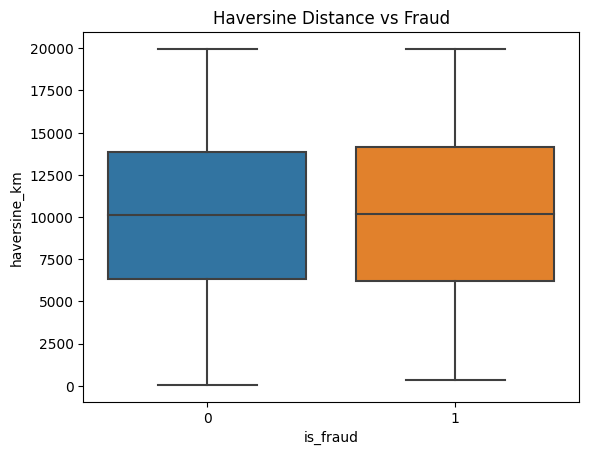

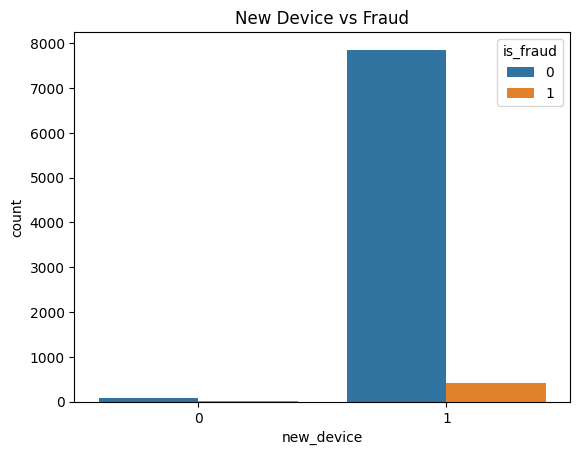

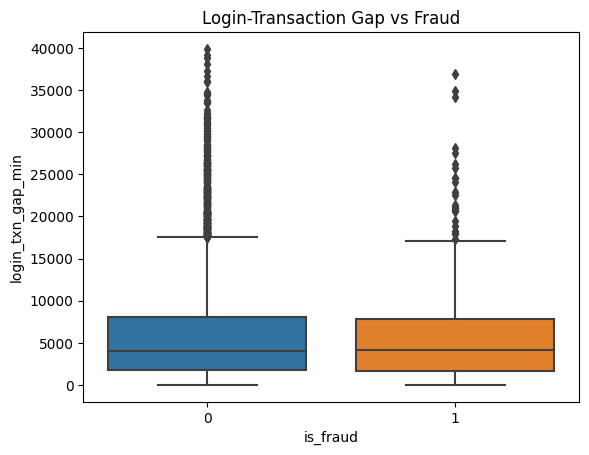

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fraud vs Non-Fraud by Haversine Distance
sns.boxplot(data=merged, x="is_fraud", y="haversine_km")
plt.title("Haversine Distance vs Fraud")
plt.show()

# Device mismatch frequency
sns.countplot(data=merged, x="new_device", hue="is_fraud")
plt.title("New Device vs Fraud")
plt.show()

# Time gap between login and transaction
sns.boxplot(data=merged, x="is_fraud", y="login_txn_gap_min")
plt.title("Login-Transaction Gap vs Fraud")
plt.show()


In [35]:
# Saved trained model to disk so it can be reused in real-time systems.
import joblib
joblib.dump(model, "fraud_rf_model.pkl")
print("Model saved as fraud_rf_model.pkl")


Model saved as fraud_rf_model.pkl


In [37]:
# Simulate scoring new transactions in real-time:
# Simulate a new batch (e.g., last 3 days)
latest_txns = merged[merged["txn_time"] >= pd.Timestamp.now() - pd.Timedelta(days=3)].copy()

# Select same features
X_new = latest_txns[["amount", "haversine_km", "new_device", "login_txn_gap_min"]]

# Predict fraud probability
latest_txns["fraud_prob"] = model.predict_proba(X_new)[:, 1]
latest_txns["fraud_pred"] = (latest_txns["fraud_prob"] >= 0.5).astype(int)

# Show high-risk cases
alerts = latest_txns[latest_txns["fraud_pred"] == 1]
print("High-risk transactions:")
alerts[["user_id", "txn_time", "amount", "haversine_km", "new_device", "fraud_prob"]].head()


High-risk transactions:


,user_id,txn_time,amount,haversine_km,new_device,fraud_prob
221,user_1040,2025-07-15 04:55:48,2035.35,3423.113731,1,1.0
504,user_1100,2025-07-15 14:20:17,5408.73,6192.428549,1,1.0
1050,user_1221,2025-07-16 01:45:04,978.79,12359.284652,1,1.0
1181,user_1250,2025-07-16 05:45:10,6781.96,10600.664318,1,1.0
1431,user_1304,2025-07-16 10:00:37,2780.38,4009.426380,1,1.0


In [38]:
alerts.to_csv("high_risk_transactions.csv", index=False)
print("High-risk alerts saved to high_risk_transactions.csv")

High-risk alerts saved to high_risk_transactions.csv
